In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [2]:
df = pd.read_json("logins.json")
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
#resampling df to 15-minute intervals
df.set_index('login_time', inplace=True)
df['count'] = 1
df = df.resample('15T').sum()

df.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


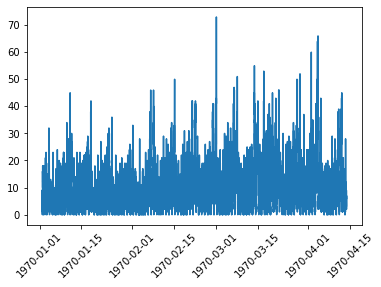

In [5]:
plt.plot(df)
plt.xticks(rotation=45);

In [6]:
df.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


<AxesSubplot:xlabel='login_time'>

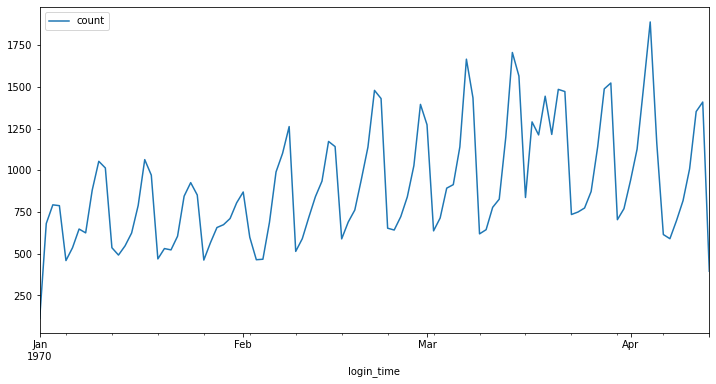

In [7]:
#resample to daily frequency
df_day = df.resample('1D').sum()
df_day.plot(kind='line',figsize=(12,6))

### There is a clear upward trend in login time across the months 

<AxesSubplot:xlabel='login_time'>

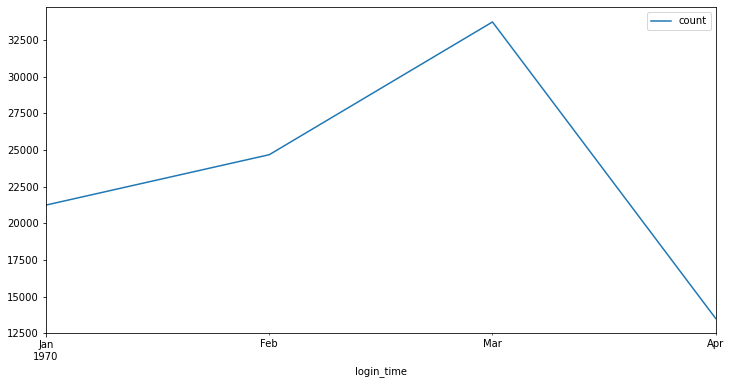

In [8]:
df_month = df.resample('M').sum()
df_month.plot(kind='line',figsize=(12,6))

### As seen above for month of march there is a peak in login time

## Answer to part 2

We can compare pre-toll vs. post-toll ridership using A/B testing. If drivers being exclusive to one city really affects business then it must be because of lack of supply, extending the waiting times for riders and driving the cost higher as well. We can then use these characteristics as the metric as basis for comparison:

Compare daily average wait times (time driver arrives vs. time rider sends request) in either city prior to the change and after
Compare daily average price during rush hour (dollar per mile cost that includes surge pricing due to demand) prior to the change and after
Compare daily rate of denied service (i.e. how many times users are turned down for being too far) prior to the change and after
These parameters can simply be extracted from the internal database before and after the implementation of the reimbursement program. The hypothesis testing will be done on each of the three metrics above. Using the first item, average wait times, as an example, the null hypothesis would be that the difference between the two means will be zero (or that they are equal).

Now, since the statistic is daily, we can use a timeframe (say, 20 days) in which each day is a trial of the experiment -- so it will be 20 days during without reimbursement period, compared with 20 days during with reimbursement period. This will ensure randomness as long as this sample is not more than 10% of the actual length of the period (so the program must go on for at least 200 days).

From there, we can simulate the assumption of our null hypothesis by shuffling the labels of our means (half of the sample is randomly assigned as have occurred with reimbursement). Let's say that the target for the average wait time is a 10-second improvement -- our observed test statistic. The p-value is then the probability that a user waited 10-seconds less than when there was no reimbursement in these randomized circumstances. If this event happens less frequently than 5% of the time, then we know it's unlikely to occur. And so encountering a difference of 10-seconds waiting time is considered to be statistically significant.

If we disprove the null hypothesis (the status quo) for all the three metrics, then we have proven that the reimbursement program works. The next step then is to contrast the cost of the total reimbursements against the gains in revenue. And as contingency, also work out the impact of reverting back to the unsubsidized approach.

## Part 3 - Modelling

In [9]:

#import data from json file
file = 'ultimate_data_challenge.json'
with open(file) as f:
    data = json.loads(f.read())
df_1 = pd.DataFrame(data)

In [10]:
df_1.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [11]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [12]:

# Since the date fields have been read in as 'object' data types, we should convert them to proper datetime format
df_1['last_trip_date'] = pd.to_datetime(df_1['last_trip_date'])
df_1['signup_date'] = pd.to_datetime(df_1['signup_date'])

In [13]:
# For ultimate black user we will convert it into numerical type from boolean
df_1['ultimate_black_user'] = df_1['ultimate_black_user'].apply(lambda x: 1 if x == True else 0)
df_1['phone'] = df_1['phone'].apply(lambda x: 1 if x == 'iPhone' else 0)

In [14]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  int64         
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int64         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int64(3), ob

<AxesSubplot:>

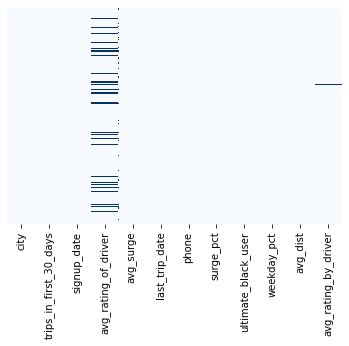

In [15]:
# Finding missing values
import seaborn as sns
sns.heatmap(df_1.isnull(), yticklabels = False, cbar = False, cmap="Blues")

### As seen above there are missing values in avg rating of driver and phone and avg rating by driver columns

In [16]:
# imputing missing values
df_1['avg_rating_of_driver'].fillna(df_1['avg_rating_of_driver'].mean(), inplace = True)
df_1['phone'].fillna(df_1['phone'].mode(), inplace = True)
df_1['avg_rating_by_driver'].fillna(df_1['avg_rating_by_driver'].mean(), inplace = True)

In [17]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  int64         
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int64         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int64(3), ob

array([[<AxesSubplot:title={'center':'trips_in_first_30_days'}>,
        <AxesSubplot:title={'center':'avg_rating_of_driver'}>,
        <AxesSubplot:title={'center':'avg_surge'}>],
       [<AxesSubplot:title={'center':'phone'}>,
        <AxesSubplot:title={'center':'surge_pct'}>,
        <AxesSubplot:title={'center':'ultimate_black_user'}>],
       [<AxesSubplot:title={'center':'weekday_pct'}>,
        <AxesSubplot:title={'center':'avg_dist'}>,
        <AxesSubplot:title={'center':'avg_rating_by_driver'}>]],
      dtype=object)

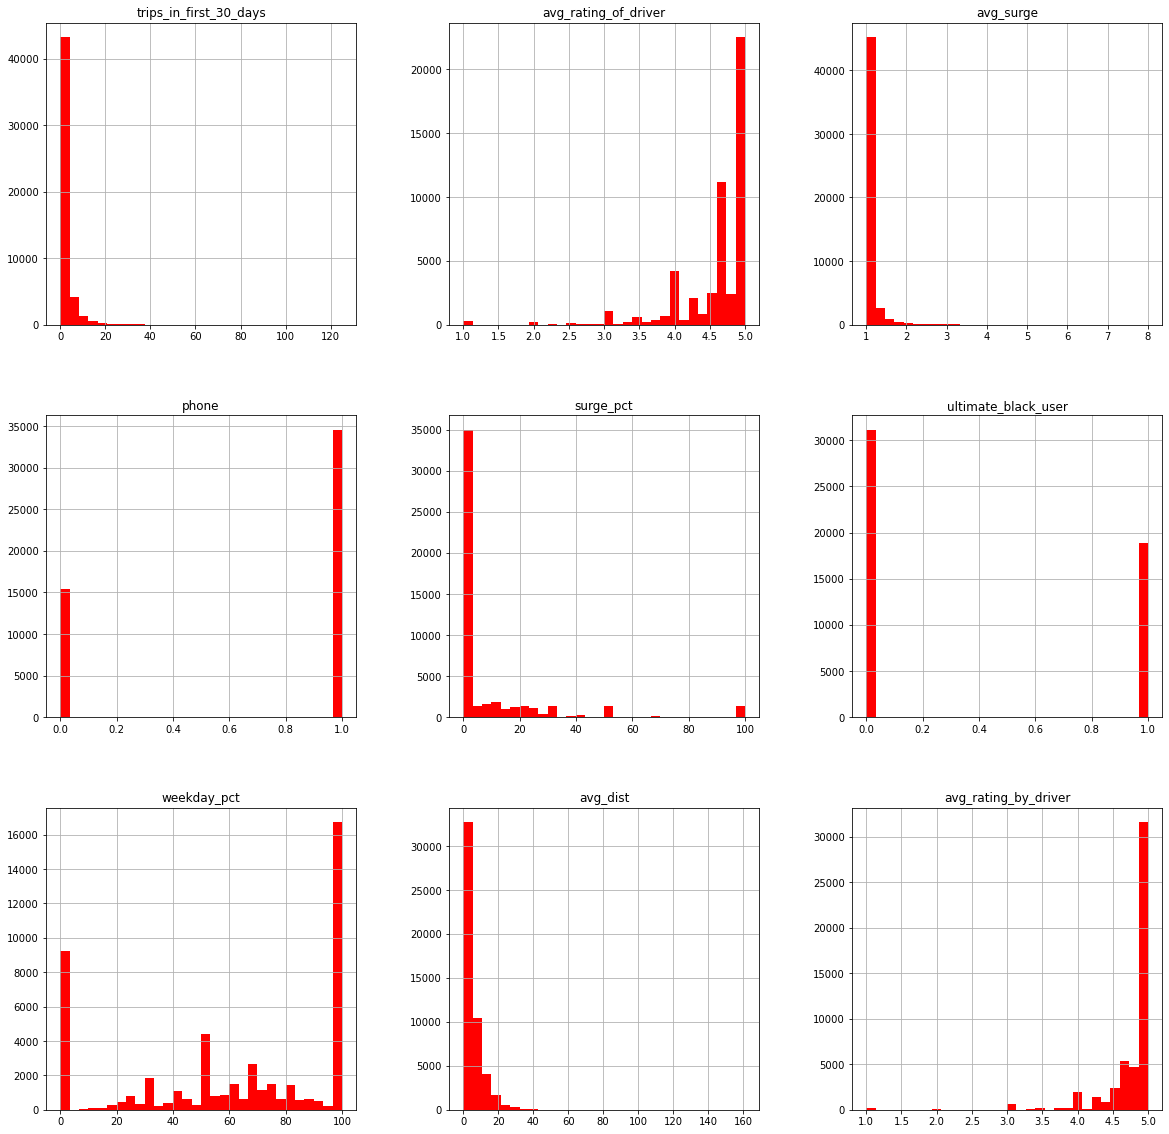

In [18]:
df_1.hist(bins = 30, figsize = (20,20), color = 'r')

### Target Variable Defination
Active users are defined as having any activity in the preceding 30 days. Though the take home challenge writeup does not indicate the current date, we can infer the latest date in the dataset as the current date for our purposes and calculate "active" users based on that date.

In [19]:
#set current date 
current_date = df_1['last_trip_date'].max()

In [20]:
df_1['active'] = df_1['last_trip_date'].apply(lambda date: 0 if (current_date-date).days>30 else 1)
df_1.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,1,15.4,1,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,0,0.0,0,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,1,0.0,0,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,1,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,0,11.8,0,82.4,3.13,4.9,0


<AxesSubplot:xlabel='active', ylabel='count'>

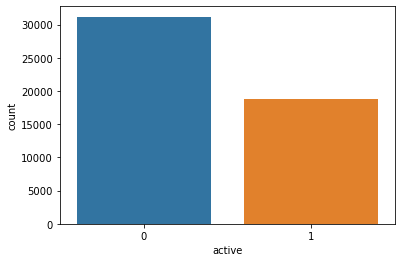

In [21]:
sns.countplot(x="active", data=df_1)

#### Active users in sixth month is less 

In [22]:
num_of_retained_users = len(df_1[df_1.active == 1].active)
num_of_lost_users = len(df_1[df_1.active == 0].active)
print('Users Retained: {}'.format(num_of_retained_users))
print('Users Lost: {}'.format(num_of_lost_users))
print('Percentage of Users Retained: {}'.format(num_of_retained_users / (num_of_retained_users + num_of_lost_users)))

Users Retained: 18804
Users Lost: 31196
Percentage of Users Retained: 0.37608


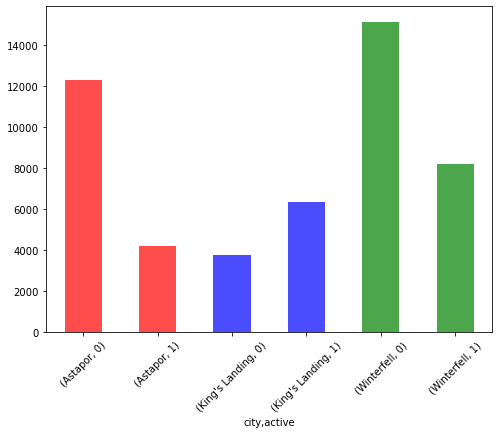

city            active
Astapor         0         12306
                1          4228
King's Landing  0          3767
                1          6363
Winterfell      0         15123
                1          8213
Name: avg_dist, dtype: int64

In [23]:

city_retainment = df_1.groupby(['city','active'])['avg_dist'].count()
city_retainment.plot(kind = 'bar', figsize = (8,6), rot = 45, color = ['r','r','b','b','g','g'], alpha = 0.7)
plt.show()
city_retainment

###  Max users retained in cities were from kings landing and Winterfell

<AxesSubplot:>

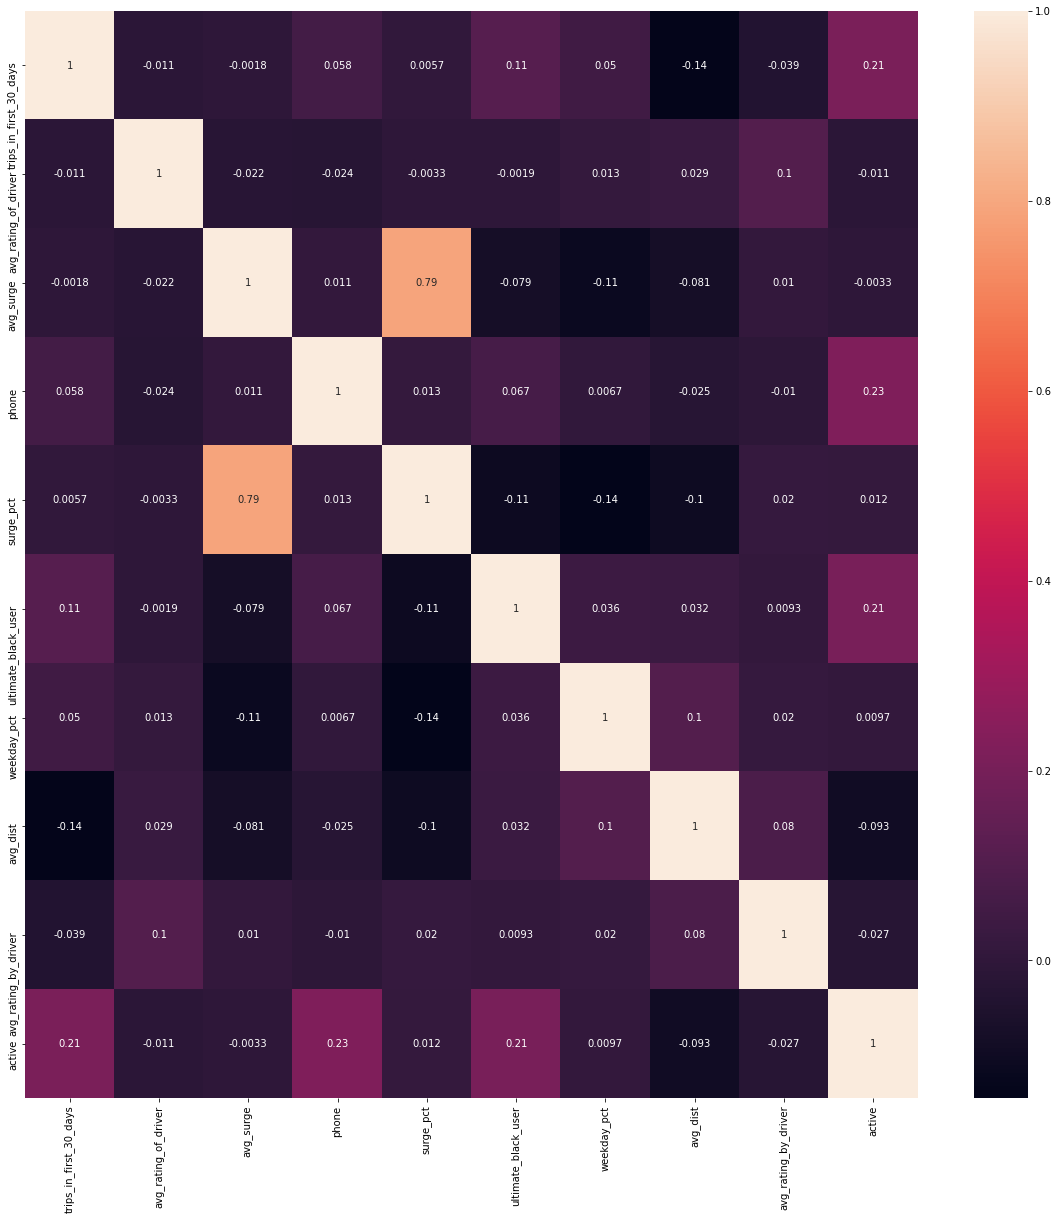

In [24]:
correlations = df_1.corr()
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(correlations, annot = True)

In [25]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  int64         
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int64         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  active                  50000 non-null  int64 

In [26]:
y = df_1['active']

In [27]:
df_1.drop(['active','signup_date','last_trip_date'],axis =1 ,inplace = True)

In [28]:
df_1.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,4.7,1.10,1,15.4,1,46.2,3.67,5.0
1,Astapor,0,5.0,1.00,0,0.0,0,50.0,8.26,5.0
2,Astapor,3,4.3,1.00,1,0.0,0,100.0,0.77,5.0
3,King's Landing,9,4.6,1.14,1,20.0,1,80.0,2.36,4.9
4,Winterfell,14,4.4,1.19,0,11.8,0,82.4,3.13,4.9


In [29]:
X_cat = df_1[['city']]
X_cat

,city
0,King's Landing
1,Astapor
2,Astapor
3,King's Landing
4,Winterfell
...,...
49995,King's Landing
49996,Astapor
49997,Winterfell
49998,Astapor


In [30]:
X_cat = pd.DataFrame(X_cat)
X_cat.head()

,city
0,King's Landing
1,Astapor
2,Astapor
3,King's Landing
4,Winterfell


In [31]:
X_cat = pd.get_dummies(X_cat) 

In [32]:
X_numerical = df_1[['trips_in_first_30_days','avg_rating_of_driver','avg_surge','phone','surge_pct','ultimate_black_user','weekday_pct','avg_dist','avg_rating_by_driver']]

In [33]:
X_numerical

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,4,4.700000,1.10,1,15.4,1,46.2,3.67,5.0
1,0,5.000000,1.00,0,0.0,0,50.0,8.26,5.0
2,3,4.300000,1.00,1,0.0,0,100.0,0.77,5.0
3,9,4.600000,1.14,1,20.0,1,80.0,2.36,4.9
4,14,4.400000,1.19,0,11.8,0,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...
49995,0,5.000000,1.00,1,0.0,0,100.0,5.63,4.2
49996,1,4.601559,1.00,1,0.0,0,0.0,0.00,4.0
49997,0,5.000000,1.00,0,0.0,1,100.0,3.86,5.0
49998,2,3.000000,1.00,1,0.0,0,100.0,4.58,3.5


In [34]:
X_all = pd.concat([X_cat, X_numerical], axis = 1)
X_all

,city_Astapor,city_King's Landing,city_Winterfell,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,0,1,0,4,4.700000,1.10,1,15.4,1,46.2,3.67,5.0
1,1,0,0,0,5.000000,1.00,0,0.0,0,50.0,8.26,5.0
2,1,0,0,3,4.300000,1.00,1,0.0,0,100.0,0.77,5.0
3,0,1,0,9,4.600000,1.14,1,20.0,1,80.0,2.36,4.9
4,0,0,1,14,4.400000,1.19,0,11.8,0,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,1,0,0,5.000000,1.00,1,0.0,0,100.0,5.63,4.2
49996,1,0,0,1,4.601559,1.00,1,0.0,0,0.0,0.00,4.0
49997,0,0,1,0,5.000000,1.00,0,0.0,1,100.0,3.86,5.0
49998,1,0,0,2,3.000000,1.00,1,0.0,0,100.0,4.58,3.5


In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X_all)

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [37]:
X_train.shape

(35000, 12)

In [38]:
X_test.shape

(15000, 12)

### Training using Logistic Regression Classifier

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [40]:
from sklearn.metrics import confusion_matrix, classification_report

print("Accuracy {} %".format( 100 * accuracy_score(y_pred, y_test)))


Accuracy 71.22666666666667 %


<AxesSubplot:>

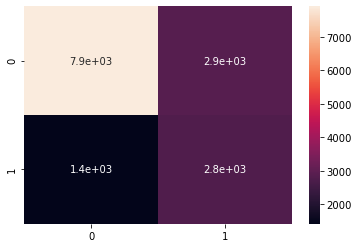

In [41]:
# Testing Set Performance
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True)


In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.85      0.79      9337
           1       0.66      0.49      0.56      5663

    accuracy                           0.71     15000
   macro avg       0.70      0.67      0.67     15000
weighted avg       0.71      0.71      0.70     15000



### Training using Random Forest Classifier

In [43]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

In [44]:
y_pred = model.predict(X_test)

<AxesSubplot:>

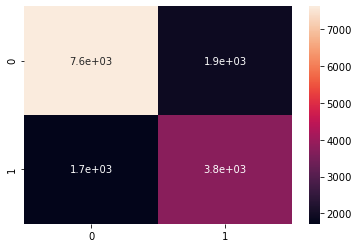

In [45]:
# Testing Set Performance
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True)

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      9337
           1       0.69      0.66      0.67      5663

    accuracy                           0.76     15000
   macro avg       0.74      0.74      0.74     15000
weighted avg       0.76      0.76      0.76     15000



Feature: 0, Score: 0.01567
Feature: 1, Score: 0.05058
Feature: 2, Score: 0.01035
Feature: 3, Score: 0.08102
Feature: 4, Score: 0.08228
Feature: 5, Score: 0.06828
Feature: 6, Score: 0.03556
Feature: 7, Score: 0.07194
Feature: 8, Score: 0.03221
Feature: 9, Score: 0.13378
Feature: 10, Score: 0.29651
Feature: 11, Score: 0.12182


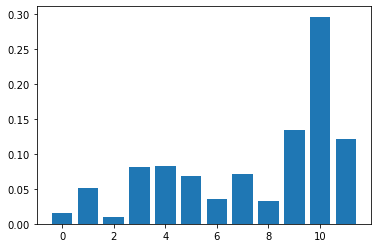

In [49]:
from matplotlib import pyplot
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [51]:
from xgboost import XGBClassifier
from matplotlib import pyplot
model = XGBClassifier()
model.fit(X_train, y_train)

C:\Users\faiza\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:05:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [52]:
y_pred = model.predict(X_test)

<AxesSubplot:>

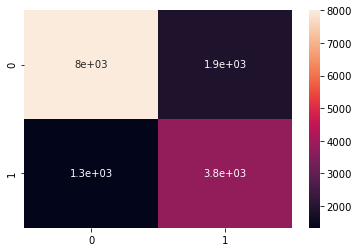

In [53]:
# Testing Set Performance
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True)

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      9337
           1       0.74      0.67      0.70      5663

    accuracy                           0.79     15000
   macro avg       0.77      0.76      0.77     15000
weighted avg       0.78      0.79      0.78     15000



Feature: 0, Score: 0.06205
Feature: 1, Score: 0.30939
Feature: 2, Score: 0.01667
Feature: 3, Score: 0.03519
Feature: 4, Score: 0.02048
Feature: 5, Score: 0.02693
Feature: 6, Score: 0.12667
Feature: 7, Score: 0.07341
Feature: 8, Score: 0.10339
Feature: 9, Score: 0.05092
Feature: 10, Score: 0.01913
Feature: 11, Score: 0.15576


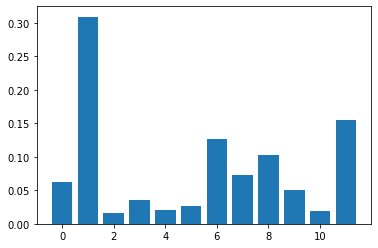

In [55]:
from matplotlib import pyplot
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Suggestions :
 * Comparing the models we found out that XGboost model is giving better accuracy of 79%
 * In Random Forest model feature importances tell us that while determining the active users, avg distance place keys role.
    Also in above model rating given by the driver and weekday_pct has an impact.
 * In XGboost model tells us that user belonging to which city also has a significant impact in user retention.   